## Preliminaries

#### Imports

In [90]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
# Allows auto reloading of modules
%load_ext autoreload
%autoreload 2

In [3]:
# Add path to src folder to the path variable 
PATH_TO_SRC = "./src"

if PATH_TO_SRC not in sys.path:
  sys.path.append(PATH_TO_SRC)

In [94]:
from data_preprocessor import DataPreprocessor
from data_clusterer import DataClusterer

#### Parameters

In [98]:
MOVIES_PATH = "./dataset/movies.csv"
GENRES_PATH = "./dataset/genres.csv"

TEST_SIZE = 0.3
RANDOM_STATE = 42

MAX_DF = 0.3 # Ignore terms that appear in > 50% of the entries
MIN_DF = 3 # Ignore terms that appear in < 5 entries
STOP_WORDS = "english"

N_COMPONENTS = 100
NORMALIZER_COPY = False

N_CLUSTERS = 20
MAX_ITER = 100
N_INIT = 1

#### Instantiated classes

In [76]:
kmeans = KMeans(n_clusters=N_CLUSTERS, max_iter=MAX_ITER, n_init=N_INIT)

## Preprocessing

In [118]:
preprocessor = DataPreprocessor(MOVIES_PATH, GENRES_PATH)
preprocessor.df_movies.head()

,id,name,date,tagline,description,minute,rating
0,1000001,Barbie,2023.0,She's everything. He's just Ken.,Barbie and Ken are having the time of their li...,114.0,3.91
1,1000002,Parasite,2019.0,Act like you own the place.,"All unemployed, Ki-taek's family takes peculia...",133.0,4.57
2,1000003,Everything Everywhere All at Once,2022.0,The universe is so much bigger than you realize.,An aging Chinese immigrant is swept up in an i...,140.0,4.32
3,1000004,Fight Club,1999.0,Mischief. Mayhem. Soap.,A ticking-time-bomb insomniac and a slippery s...,139.0,4.27
4,1000005,Interstellar,2014.0,Mankind was born on Earth. It was never meant ...,The adventures of a group of explorers who mak...,169.0,4.32


In [119]:
preprocessor.df_genres.head()

,id,genre
0,1000001,Comedy
1,1000001,Fantasy
2,1000001,Adventure
3,1000002,Comedy
4,1000002,Thriller


#### Data Cleaning and Splitting

In [120]:
preprocessor.handleDataFrame()
X_train, X_test, y_train, y_test = preprocessor.splitData(TEST_SIZE, RANDOM_STATE)
X_train_desc_only = X_train.description

Reduced Length:  540740
Reduced Columns:  Index(['id', 'genre', 'name', 'description', 'rating'], dtype='object')


#### Vectorization

In [121]:
X_tfidf, features = preprocessor.vectorizeData(X_train_desc_only, MAX_DF, MIN_DF, STOP_WORDS)

Vectorized in 7.166 s
# of Samples: 378518
# of Features: 81591
% of Nonzero Entries: 0.010


#### Dimensionality Reduction

In [122]:
genres = preprocessor.countGenres()
X_lsa, lsa = preprocessor.reduceDim(X_tfidf, N_COMPONENTS, NORMALIZER_COPY)

# of Genres:  19
Unique Genres:
                     id
genre                  
Action            19194
Adventure          8827
Animation         39939
Comedy            89726
Crime             15459
Documentary      138760
Drama            153192
Family            12476
Fantasy            9163
History            7233
Horror            31020
Music             29414
Mystery            8362
Romance           23825
Science Fiction    9519
TV Movie          10236
Thriller          21435
War                4647
Western            6205
LSA done in 16.075 s
Explained variance of the SVD step: 7.8%


## Clustering and Optmizing K

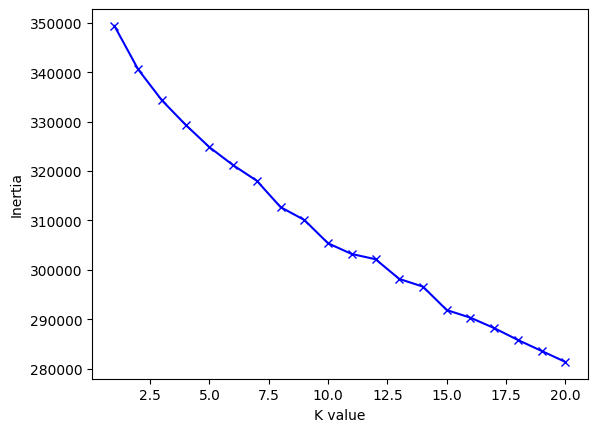

In [99]:
clusterer = DataClusterer(X_lsa, N_CLUSTERS, MAX_ITER, N_INIT)
K, inertias = clusterer.computeKMeansInertia()

In [104]:
optimal_k = 15
centers, y_kmeans, inertia = clusterer.computeKMeans(optimal_k)
clusterer.getClusters(optimal_k, centers, features, lsa)

Cluster 0: old year years new family mother girl life father boy school time home friend friends son lives daughter young 12 
Cluster 1: film short directed director feature based animated experimental films new silent produced time work life festival people footage history shot 
Cluster 2: life new family young film years death work time change real people living way woman lives career mother wife father 
Cluster 3: young woman girl husband finds family mother father boy couple home men meets new man beautiful people women help mysterious 
Cluster 4: live band music concert tour rock album footage performance special songs dvd video recorded musical interviews featuring new singer filmed 
Cluster 5: man young life woman wife finds old family father home meets mysterious gets tries night new time death girl girlfriend 
Cluster 6: love falls girl fall life young man meets woman daughter story father family relationship time married new finds beautiful friend 
Cluster 7: series tv events

In [142]:
X_train_clustered = X_train.assign(cluster=y_kmeans)
X_train_clustered.loc[X_train_clustered['cluster'] == 8].sort_values('rating', ascending=False).head(10)

,id,genre,name,description,rating,cluster
3497,1003499,Comedy,Fullmetal Alchemist: Brotherhood,Edward and Alphonse Elric's reckless disregard...,4.63,8
182,1000183,History,Schindler's List,The true story of how businessman Oskar Schind...,4.51,8
1047,1001048,Drama,Ran,"With Ran, legendary director Akira Kurosawa re...",4.50,8
452,1000453,Western,"The Good, the Bad and the Ugly",While the Civil War rages on between the Union...,4.49,8
2859,1002861,War,The Human Condition I: No Greater Love,"During the Second World War, Japanese conscien...",4.48,8
15,1000016,Thriller,The Dark Knight,Batman raises the stakes in his war on crime. ...,4.46,8
896,1000897,War,Paths of Glory,A commanding officer defends three scapegoats ...,4.45,8
259,1000260,Drama,Apocalypse Now,"At the height of the Vietnam war, Captain Benj...",4.44,8
8232,1008252,Documentary,The Vietnam War,An immersive 360-degree narrative telling the ...,4.43,8
295,1000296,Drama,The Pianist,The true story of pianist Władysław Szpilman's...,4.36,8
